# Installs and Package Imports

In [1]:
!pip install shap==0.39.0
!pip3 install mxnet-mkl==1.6.0 numpy==1.23.1 #addresses the numpy boolean issue

In [8]:
!pip install kaggle

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report

from prophet import Prophet

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import NearestNeighbors

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM

import shap
shap.initjs()

# Functions

In [4]:
def split_datetime(df, col):
    # Encode datetime into year, month, day, hour, minute, and second columns
    df['year'] = df[col].dt.year
    df['month'] = df[col].dt.month
    df['day'] = df[col].dt.day
    df['hour'] = df[col].dt.hour
    df['minute'] = df[col].dt.minute
    df['second'] = df[col].dt.second

    return df

In [5]:
def encode_feature_by_buckets(df, feature_name, num_buckets, show_bucket_ranges):
    """
    Encode a numerical feature by dividing its range into specified number of buckets.

    Args:
        df (pd.DataFrame): Input dataframe containing the feature.
        feature_name (str): Name of the feature to be encoded.
        num_buckets (int): Number of buckets to divide the feature range into.
        show_bucket_ranges (bool): Flag to print the bucket ranges.

    Returns:
        pd.DataFrame: Input dataframe with the encoded feature in place of the original feature.
    """
    # Get the feature values
    feature_values = df[feature_name]

    # Calculate the min and max values of the feature
    min_value = feature_values.min()
    max_value = feature_values.max()

    # Calculate the bucket width
    bucket_width = (max_value - min_value) / num_buckets

    # Encode the feature into buckets as integers
    df = df.drop(columns=[feature_name])
    df[feature_name] = pd.cut(feature_values, bins=num_buckets, labels=False)

    # Calculate the range of each bucket
    bucket_ranges = [(min_value + i * bucket_width, min_value + (i + 1) * bucket_width) for i in range(num_buckets)]

    if show_bucket_ranges:
      # Print the bucket ranges
      print(f"Bucket Ranges for {feature_name}:")
      for i, (start, end) in enumerate(bucket_ranges):
          print(f"Bucket {i+1}: {start:.2f} - {end:.2f}")

    return df

# Data Import

In [11]:
!kaggle datasets download -d thegoanpanda/fault-prediction-in-tablet-press-equipment

Dataset URL: https://www.kaggle.com/datasets/thegoanpanda/fault-prediction-in-tablet-press-equipment
License(s): MIT
  0% 0.00/72.1k [00:00<?, ?B/s]
100% 72.1k/72.1k [00:00<00:00, 55.5MB/s]


In [12]:
# Load the dataset
# Found here: https://www.kaggle.com/datasets/thegoanpanda/fault-prediction-in-tablet-press-equipment?resource=download
df = pd.read_csv("/content/fault-prediction-in-tablet-press-equipment.zip")

# Display the first few rows of the dataset
df.head()

,Pressure,Temperature,Speed,Vibration,Humidity,Maintenance_Cycles,Failure
0,62.512145,28.220422,758.141650,0.292994,49.799312,13,0
1,69.941139,32.452611,590.881799,9.463787,48.547032,10,1
2,60.912694,23.096572,741.749043,5.567093,58.904469,6,1
3,76.515107,21.693767,680.608030,8.567299,61.665603,12,1
4,82.498197,30.125321,669.042205,3.645664,46.897832,13,0


# Continuous Model

## Data Preprocessing

In [ ]:
# Create a Datetime dataframe with one data point per hour
start_date = '2023-01-01'
end_date = '2023-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='H')

# Create a new DataFrame with Datetime index
datetime_df = pd.DataFrame(index=date_range)

# Create a new 'Datetime' column in the original DataFrame
df['Datetime'] = datetime_df.index[:len(df)] # Slice the datetime index to match the length of df

# Set the 'Datetime' column as the index
df = df.set_index('Datetime')

# Now df contains one data point per hour with Datetime index for the length of the original data
print(df.head())

                      Pressure  Temperature       Speed  Vibration   Humidity  \
Datetime                                                                        
2023-01-01 00:00:00  62.512145    28.220422  758.141650   0.292994  49.799312   
2023-01-01 01:00:00  69.941139    32.452611  590.881799   9.463787  48.547032   
2023-01-01 02:00:00  60.912694    23.096572  741.749043   5.567093  58.904469   
2023-01-01 03:00:00  76.515107    21.693767  680.608030   8.567299  61.665603   
2023-01-01 04:00:00  82.498197    30.125321  669.042205   3.645664  46.897832   

                     Maintenance_Cycles  Failure  
Datetime                                          
2023-01-01 00:00:00                  13        0  
2023-01-01 01:00:00                  10        1  
2023-01-01 02:00:00                   6        1  
2023-01-01 03:00:00                  12        1  
2023-01-01 04:00:00                  13        0  


In [ ]:
# Target variable is the binary Failure feature
X = df.drop(columns=['Failure'])
y = df['Failure']

In [ ]:
# Seperate the data from the last 24 measurements for training
X_train = X[:-24]
y_train = y[:-24]

In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

## Train Failure Prediction Model

In [ ]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

## Predict Next Day Faults

In [ ]:
# Predict faults for the last day (24 measurements)
X_last_day = X.iloc[-24:]
X_last_day_scaled = scaler.transform(X_last_day)
y_pred_last_day = clf.predict(X_last_day_scaled)

In [ ]:
# Evaluate the model accuracy with real values for the last 24 measurements
accuracy_last_day = accuracy_score(y[-24:], y_pred_last_day)
print(f"Accuracy for the last day: {accuracy_last_day:.2f}")

Accuracy for the last day: 1.00


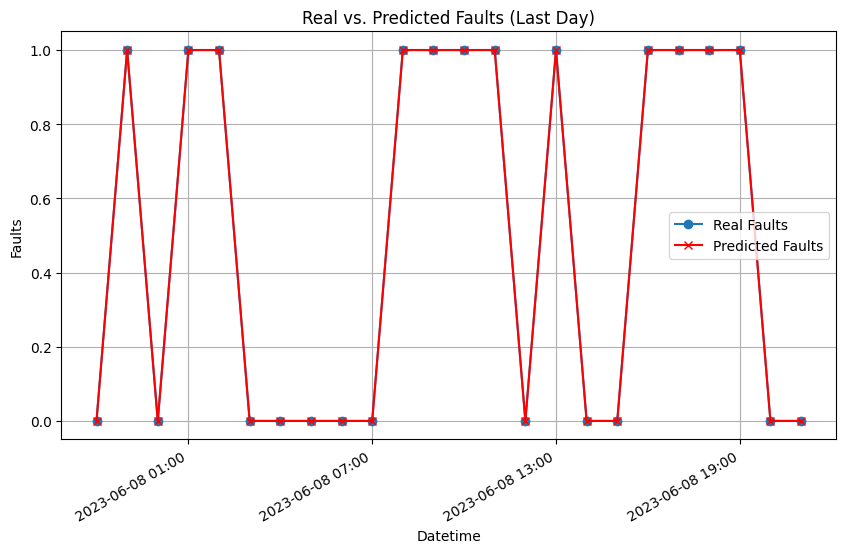

In [ ]:
# Create a time series plot of real vs. predicted fault values for the last 3 days
plt.figure(figsize=(10, 6))
plt.plot(y.index[-24:], y[-24:], label='Real Faults', marker='o')
plt.plot(y.index[-24:], y_pred_last_day, label='Predicted Faults', marker='x', color='red')

# Format the x-axis to show datetime values
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.gcf().autofmt_xdate()

plt.xlabel('Datetime')
plt.ylabel('Faults')
plt.title('Real vs. Predicted Faults (Last Day)')
plt.legend()
plt.grid(True)
plt.show()

## Explain Predictions

In [ ]:
df.reset_index(inplace=True)

df = split_datetime(df, 'Datetime')

df = df.drop(columns=['Datetime', 'minute', 'second'])

df.head()

,Pressure,Temperature,Speed,Vibration,Humidity,Maintenance_Cycles,Failure,year,month,day,hour
0,62.512145,28.220422,758.141650,0.292994,49.799312,13,0,2023,1,1,0
1,69.941139,32.452611,590.881799,9.463787,48.547032,10,1,2023,1,1,1
2,60.912694,23.096572,741.749043,5.567093,58.904469,6,1,2023,1,1,2
3,76.515107,21.693767,680.608030,8.567299,61.665603,12,1,2023,1,1,3
4,82.498197,30.125321,669.042205,3.645664,46.897832,13,0,2023,1,1,4


In [ ]:
# Target variable is the binary Failure feature
X = df.drop(columns=['Failure'])
y = df['Failure']

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [ ]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predict faults
y_pred = clf.predict(X_test_scaled)

In [ ]:
# Evaluate the model accuracy with real values for the last 24 measurements
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for the model: {accuracy:.2f}")

Accuracy for the model: 0.96


In [ ]:
# Initialize the SHAP explainer
explainer = shap.Explainer(clf, X_train_scaled)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_scaled)

 99%|===================| 1512/1526 [00:21<00:00]       

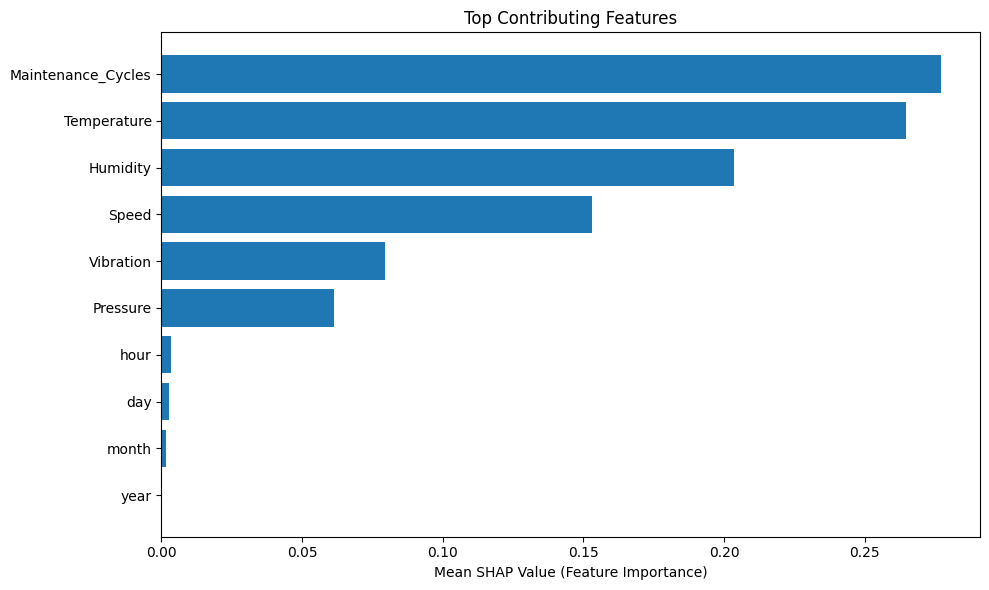

In [ ]:
# Create a bar plot for top features
feature_importances = np.abs(shap_values.values).mean(axis=0).sum(axis=1) # Sum over classes for each feature
sorted_idx = np.argsort(feature_importances)[::-1]
top_features = X.columns[sorted_idx] # Now sorted_idx is 1D and can be used to index

plt.figure(figsize=(10, 6))
plt.barh(top_features, feature_importances[sorted_idx])
plt.xlabel("Mean SHAP Value (Feature Importance)")
plt.title("Top Contributing Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Discrete Data

## Data Preprocessing

In [ ]:
# Load the dataset
# Found here: https://www.kaggle.com/datasets/thegoanpanda/fault-prediction-in-tablet-press-equipment?resource=download
df = pd.read_csv('/content/drive/MyDrive/Datasets/Tablet_press_data.csv')

# Display the first few rows of the dataset
df.head()

,Pressure,Temperature,Speed,Vibration,Humidity,Maintenance_Cycles,Failure
0,62.512145,28.220422,758.141650,0.292994,49.799312,13,0
1,69.941139,32.452611,590.881799,9.463787,48.547032,10,1
2,60.912694,23.096572,741.749043,5.567093,58.904469,6,1
3,76.515107,21.693767,680.608030,8.567299,61.665603,12,1
4,82.498197,30.125321,669.042205,3.645664,46.897832,13,0


In [ ]:
# Create a Datetime dataframe with one data point per hour
start_date = '2023-01-01'
end_date = '2023-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='H')

# Create a new DataFrame with Datetime index
datetime_df = pd.DataFrame(index=date_range)

# Create a new 'Datetime' column in the original DataFrame
df['Datetime'] = datetime_df.index[:len(df)] # Slice the datetime index to match the length of df

# Set the 'Datetime' column as the index
df = df.set_index('Datetime')

# Now df contains one data point per hour with Datetime index for the length of the original data
df.head()

,Pressure,Temperature,Speed,Vibration,Humidity,Maintenance_Cycles,Failure
Datetime,,,,,,,
2023-01-01 00:00:00,62.512145,28.220422,758.141650,0.292994,49.799312,13,0
2023-01-01 01:00:00,69.941139,32.452611,590.881799,9.463787,48.547032,10,1
2023-01-01 02:00:00,60.912694,23.096572,741.749043,5.567093,58.904469,6,1
2023-01-01 03:00:00,76.515107,21.693767,680.608030,8.567299,61.665603,12,1
2023-01-01 04:00:00,82.498197,30.125321,669.042205,3.645664,46.897832,13,0


In [ ]:
# Set number of buckets for encoding
num_buckets = 10

# Encode the features into buckets
df_encoded = encode_feature_by_buckets(df, feature_name="Pressure", num_buckets=num_buckets, show_bucket_ranges=False)
df_encoded = encode_feature_by_buckets(df_encoded, feature_name="Temperature", num_buckets=num_buckets, show_bucket_ranges=False)
df_encoded = encode_feature_by_buckets(df_encoded, feature_name="Speed", num_buckets=num_buckets, show_bucket_ranges=False)
df_encoded = encode_feature_by_buckets(df_encoded, feature_name="Vibration", num_buckets=num_buckets, show_bucket_ranges=False)
df_encoded = encode_feature_by_buckets(df_encoded, feature_name="Humidity", num_buckets=num_buckets, show_bucket_ranges=False)
df_encoded.head()

,Maintenance_Cycles,Failure,Pressure,Temperature,Speed,Vibration,Humidity
Datetime,,,,,,,
2023-01-01 00:00:00,13,0,2,4,5,0,4
2023-01-01 01:00:00,10,1,3,6,1,9,4
2023-01-01 02:00:00,6,1,2,1,4,5,7
2023-01-01 03:00:00,12,1,5,0,3,8,7
2023-01-01 04:00:00,13,0,6,5,3,3,4


In [ ]:
# Target variable is the binary Failure feature
X = df_encoded.drop(columns=['Failure'])
y = df_encoded['Failure']

In [ ]:
# Seperate the data from the last 24 measurements for training
X_train = X[:-24]
y_train = y[:-24]

## Train Prediction Model

In [ ]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Predict Next Day

In [ ]:
# Predict faults for the last day (24 measurements)
X_last_day = X.iloc[-24:]
y_pred_last_day = clf.predict(X_last_day)

In [ ]:
# Evaluate the model accuracy with real values for the last 24 measurements
accuracy_last_day = accuracy_score(y[-24:], y_pred_last_day)
print(f"Accuracy for the last day: {accuracy_last_day:.2f}")

Accuracy for the last day: 1.00


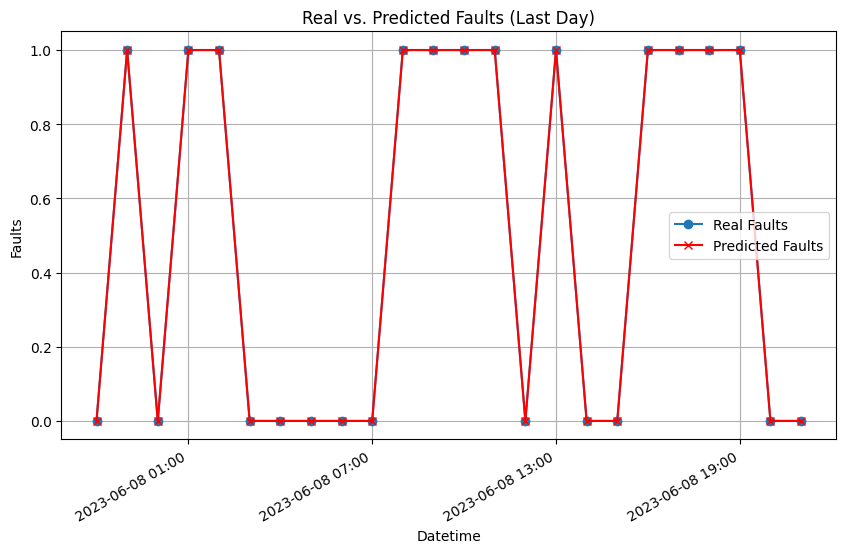

In [ ]:
# Create a time series plot of real vs. predicted fault values for the last 3 days
plt.figure(figsize=(10, 6))
plt.plot(y.index[-24:], y[-24:], label='Real Faults', marker='o')
plt.plot(y.index[-24:], y_pred_last_day, label='Predicted Faults', marker='x', color='red')

# Format the x-axis to show datetime values
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.gcf().autofmt_xdate()

plt.xlabel('Datetime')
plt.ylabel('Faults')
plt.title('Real vs. Predicted Faults (Last Day)')
plt.legend()
plt.grid(True)
plt.show()

## Explain Predictions

In [ ]:
df_encoded.reset_index(inplace=True)

df_encoded = split_datetime(df_encoded, 'Datetime')

df_encoded = df_encoded.drop(columns=['Datetime', 'minute', 'second'])

df_encoded.head()

,Maintenance_Cycles,Failure,Pressure,Temperature,Speed,Vibration,Humidity,year,month,day,hour
0,13,0,2,4,5,0,4,2023,1,1,0
1,10,1,3,6,1,9,4,2023,1,1,1
2,6,1,2,1,4,5,7,2023,1,1,2
3,12,1,5,0,3,8,7,2023,1,1,3
4,13,0,6,5,3,3,4,2023,1,1,4


In [ ]:
# Target variable is the binary Failure feature
X = df_encoded.drop(columns=['Failure'])
y = df_encoded['Failure']

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Evaluate the model accuracy with real values for the last 24 measurements
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for the model: {accuracy:.2f}")

Accuracy for the model: 0.96


In [ ]:
# Initialize the SHAP explainer
explainer = shap.Explainer(clf, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

 99%|===================| 1510/1526 [00:22<00:00]       

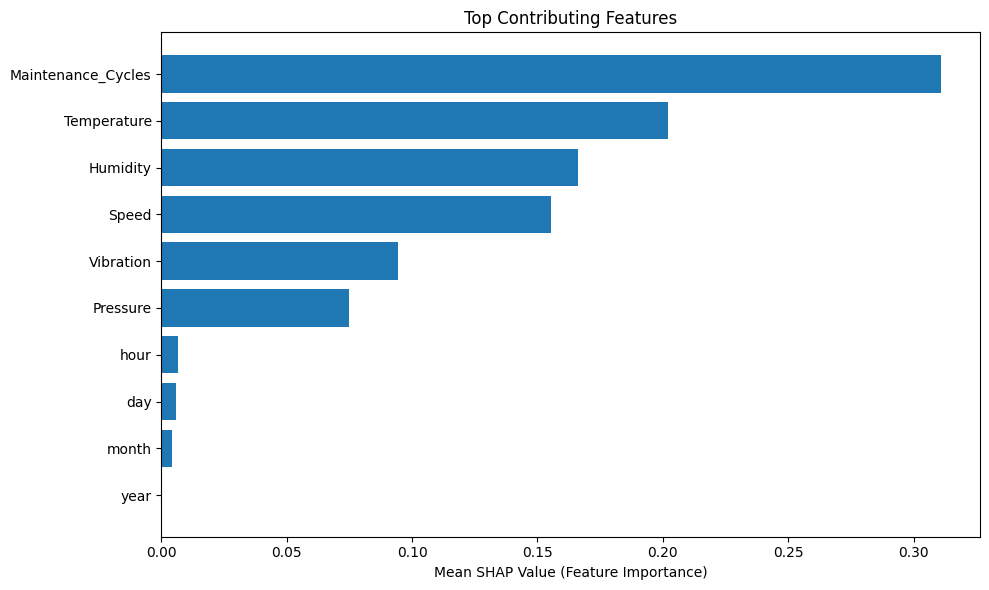

In [ ]:
# Create a bar plot for top features
feature_importances = np.abs(shap_values.values).mean(axis=0).sum(axis=1) # Sum over classes for each feature
sorted_idx = np.argsort(feature_importances)[::-1]
top_features = X.columns[sorted_idx] # Now sorted_idx is 1D and can be used to index

plt.figure(figsize=(10, 6))
plt.barh(top_features, feature_importances[sorted_idx])
plt.xlabel("Mean SHAP Value (Feature Importance)")
plt.title("Top Contributing Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()